In [1]:
%matplotlib notebook
import tensorwatch as tw

In [2]:
train = tw.WatcherClient(port=0)
test = tw.WatcherClient(port=1)

<IPython.core.display.Javascript object>


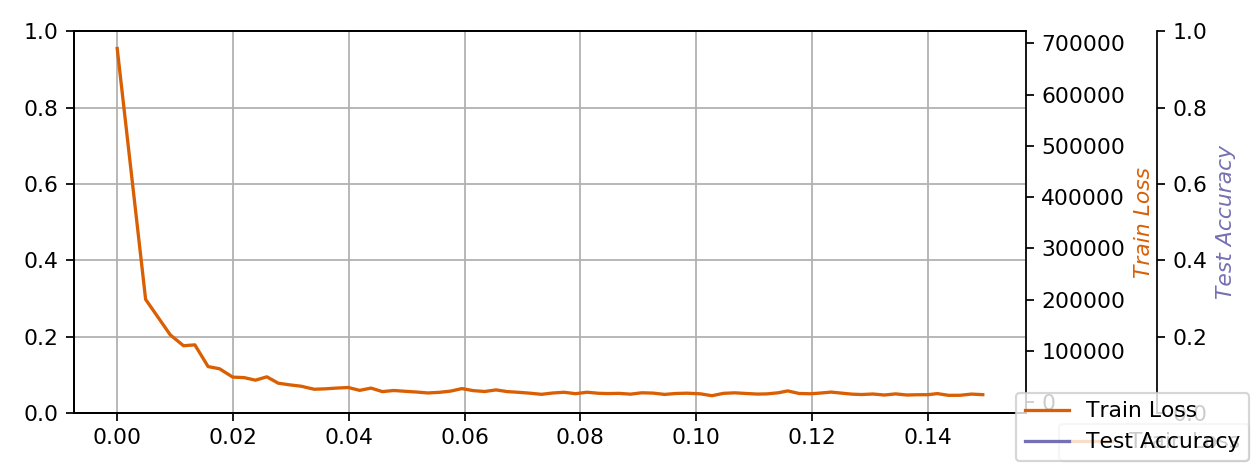

In [3]:
loss_stream = train.create_stream(expr='lambda v:(v.metrics.epochf, v.metrics.batch_loss)', event_name='batch')
loss_plot = tw.Visualizer(loss_stream, vis_type='line', 
                          xtitle='Epoch', ytitle='Train Loss')
loss_plot.show()

In [4]:
test_acc_stream = test.create_stream(expr='lambda d:(d.epochf, d.metrics.batch_accuracy)', event_name='batch')
test_acc_plot = tw.Visualizer(test_acc_stream, vis_type='line', host=loss_plot,
                              xtitle='Epoch', ytitle='Test Accuracy', yrange=(0,))
test_acc_plot.show()

<IPython.core.display.Javascript object>


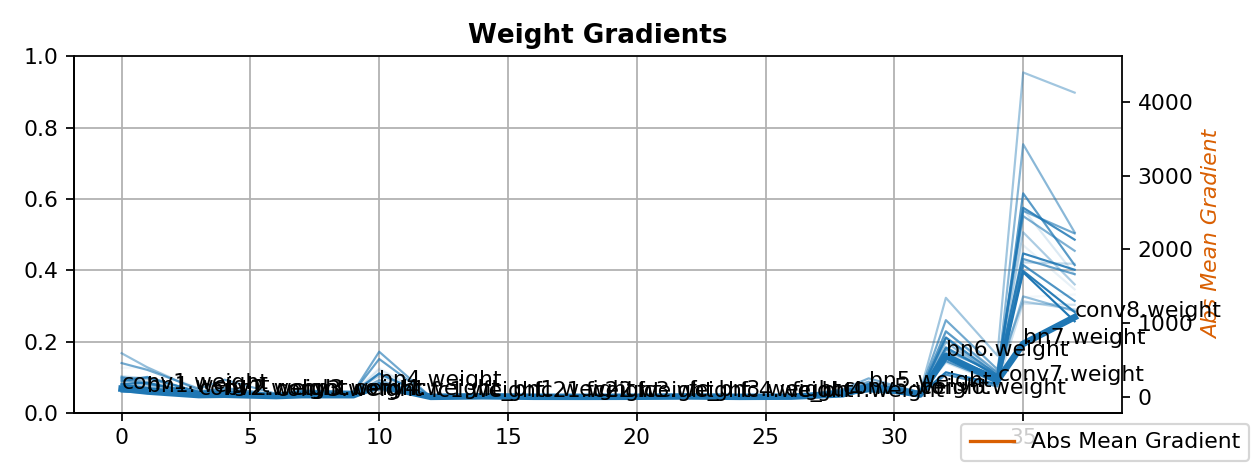

In [5]:
grads_stream = train.create_stream(expr='lambda d: grads_abs_mean(d.model)', 
                                   event_name='batch', throttle=1)
grads_plot = tw.Visualizer(grads_stream, vis_type='line', title="Weight Gradients", clear_after_each=True,
                          xtitle='Layer', ytitle='Abs Mean Gradient', history_len=20)
grads_plot.show()

<IPython.core.display.Javascript object>


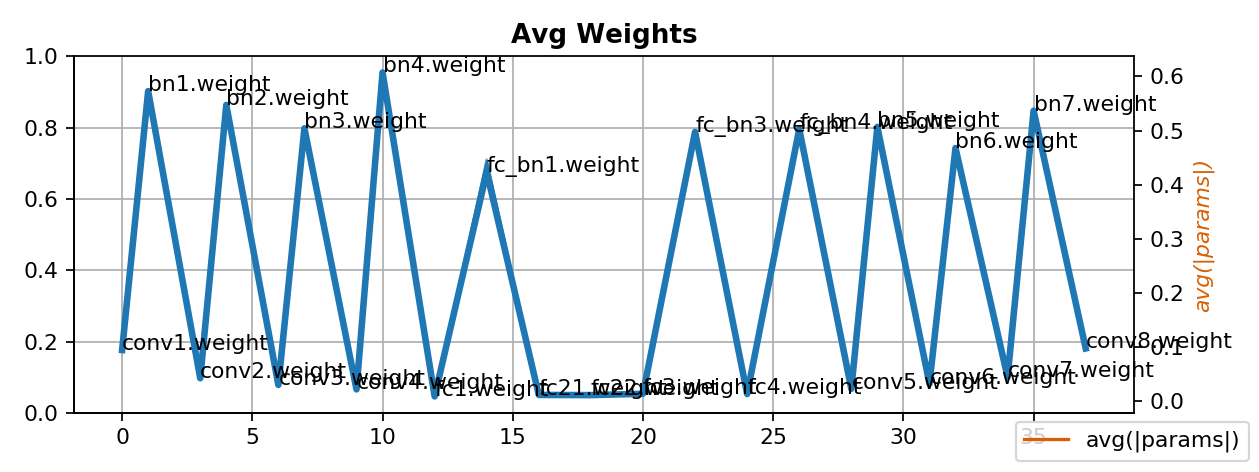

In [6]:
avg_weights_stream = train.create_stream(expr='lambda d: weights_abs_mean(d.model)', 
                                   event_name='batch', throttle=1)
avg_weights_plot = tw.Visualizer(avg_weights_stream, vis_type='line', title="Avg Weights", clear_after_each=True,
                          xtitle='Layer', ytitle='avg(|params|)', history_len=20)
avg_weights_plot.show()

<IPython.core.display.Javascript object>


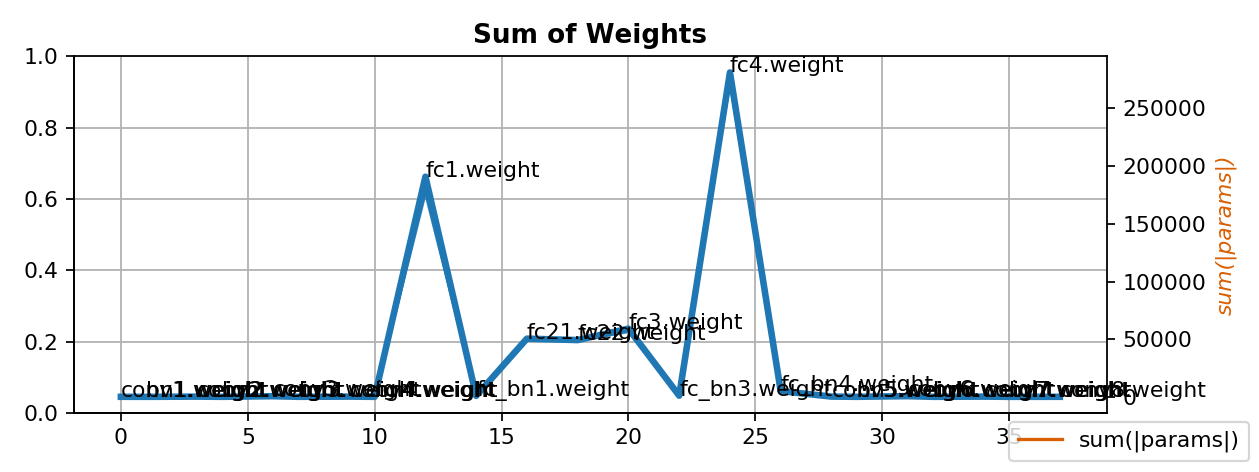

In [7]:
sum_weights_stream = train.create_stream(expr='lambda d: weights_abs_sum(d.model)', 
                                   event_name='batch', throttle=1)
sum_weights_plot = tw.Visualizer(sum_weights_stream, vis_type='line', title="Sum of Weights", clear_after_each=True,
                          xtitle='Layer', ytitle='sum(|params|)', history_len=20)
sum_weights_plot.show()

<IPython.core.display.Javascript object>


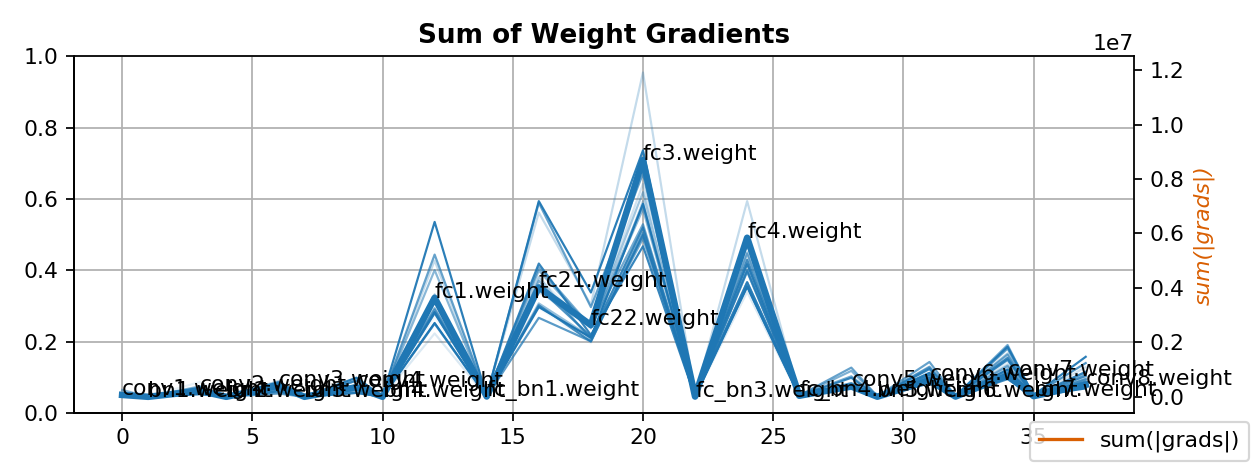

In [8]:
sum_weights_stream = train.create_stream(expr='lambda d: grads_abs_sum(d.model)', 
                                         event_name='batch', throttle=1)
sum_weights_plot = tw.Visualizer(sum_weights_stream, 
                                 vis_type='line', title="Sum of Weight Gradients", clear_after_each=True,
                                 xtitle='Layer', ytitle='sum(|grads|)', history_len=20)
sum_weights_plot.show()

<IPython.core.display.Javascript object>


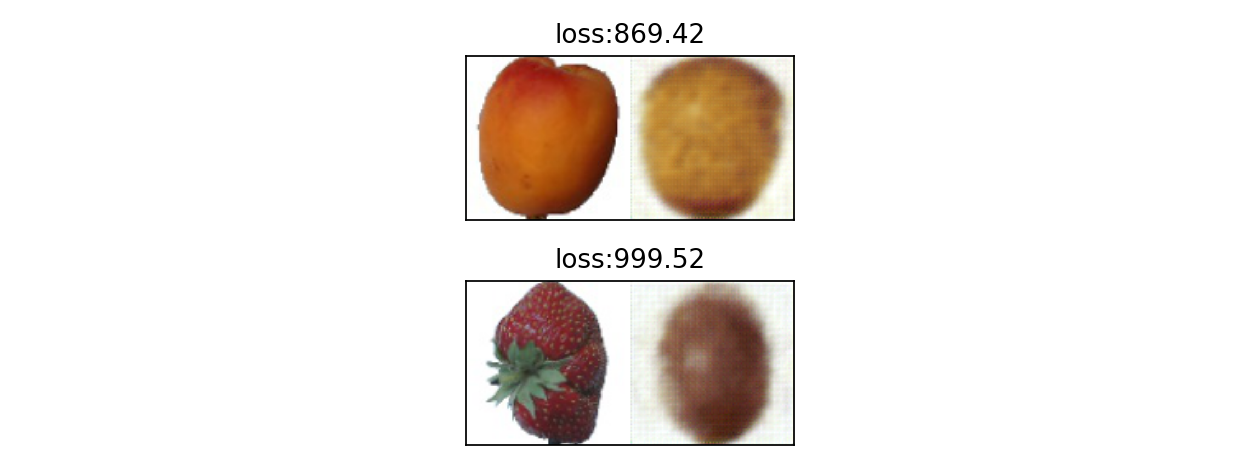

In [10]:
rand_pred = train.create_stream(expr="topk_all(l, \
            batch_vals=lambda b: (b.batch.loss_all, (b.batch.input, b.batch.output)), \
            out_f=image_image_outf, order='rnd', k=2)", event_name='batch', throttle=1)
rand_pred_plot = tw.Visualizer(rand_pred, vis_type='image', title="Random Predictions", 
                               img_width=100, img_height=100, viz_img_scale=3, cols=1, rows=2)
rand_pred_plot.show()